### Limma voom analysis of AD/PD dataset

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(50))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
##load ATAC-seq raw read counts
#data=read.table('../adpd.atac.idr.counts.txt.gz',header=TRUE,sep='\t')

##concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
#rownames(data)=paste(data$chrom,data$start,data$end,sep="_")
#data$chrom=NULL
#data$start=NULL
#data$end=NULL

#data=data[rowSums(data)>0,]


In [3]:
#load ATAC-seq data normalized counts. These were generated below w/ voom function 
E=read.table("idr.voom.qnorm.txt",header=TRUE,sep='\t',row.names=1)


In [4]:
#load the metadata
batches=read.table("../batches.filtered.csv",header=TRUE,sep='\t')

## Normalize the data with voom 

In [5]:
#tpm=voom(data,normalize.method = "quantile")
#E=tpm$E
#E=round(E,2)

In [6]:
#save the normalized data so we can load those values directly next time
write.table(E,file="idr.voom.qnorm.txt",quote=FALSE,sep='\t')

## Perform PCA analysis before SVA correction, find which covariates account for axes of variation

In [7]:
data.pca=prcomp(t(E))

In [8]:
var_explained=as.character(round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2))


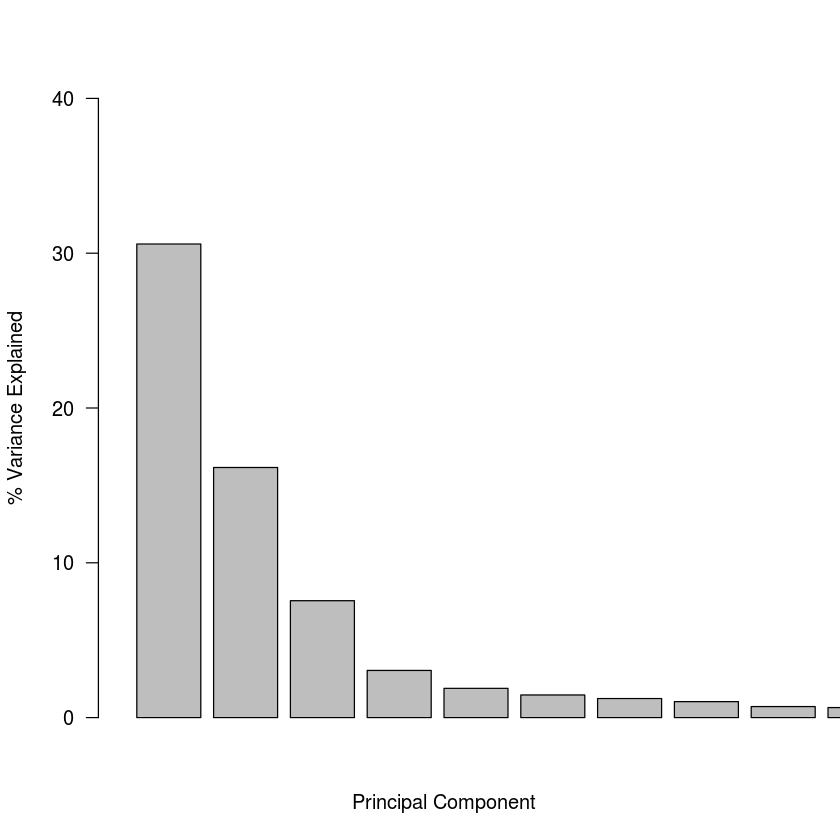

In [9]:
barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,ylab="% Variance Explained",xlab="Principal Component",ylim=c(0,40), xlim=c(0,10))

In [10]:
nrow(E)

[1] 385725

In [11]:
var_explained[0:10]

[1] "30.59" "16.16" "7.55"  "3.05"  "1.89"  "1.46"  "1.23"  "1.03"  "0.71" 
[10] "0.65"

In [12]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)

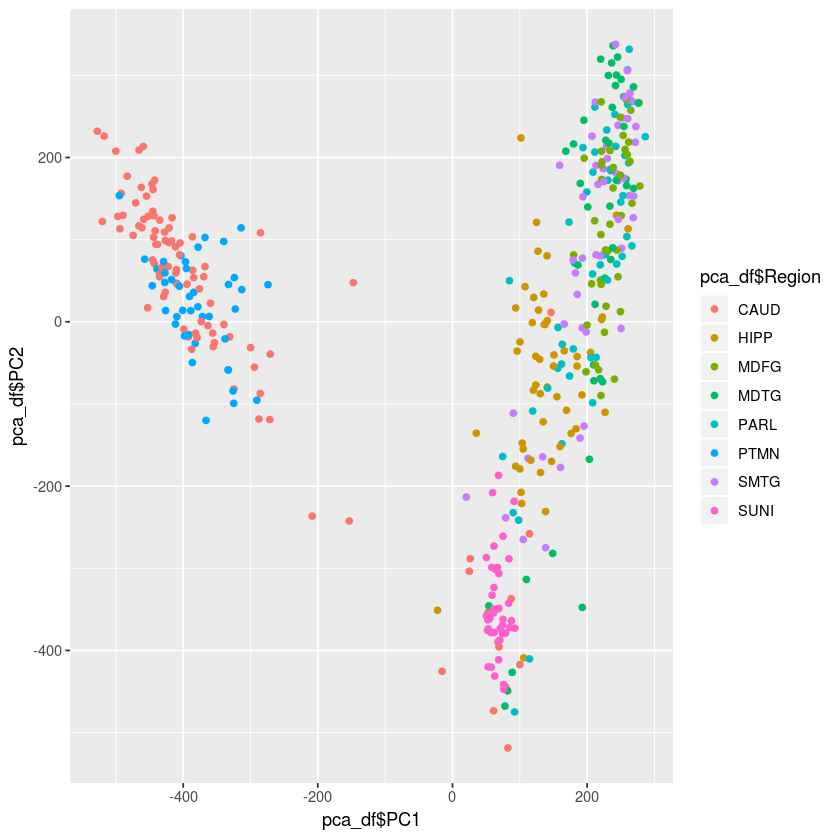

In [13]:
ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Region))+
geom_point()

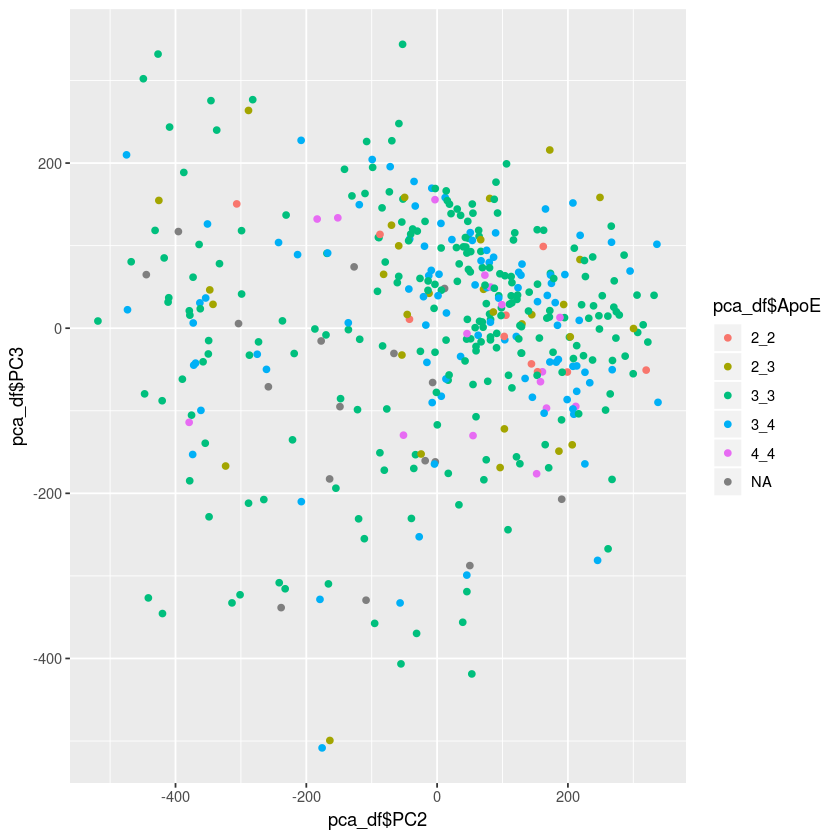

In [14]:
ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$ApoE))+
geom_point()
#Type	TypeMod	Region	RegionMod	Cohort	TissueCenter	Batch	Gender	expired_age	PMI	ApoE

In [16]:
Grouping <- factor(paste0(batches$Cohort,".",batches$RegionMod, ".", batches$TypeMod))

In [17]:
batches$Grouping=Grouping

In [18]:
colSums(is.na(batches))

Sample      NewName         Type      TypeMod       Region    RegionMod 
           0            0            0            0            0            0 
      Cohort TissueCenter        Batch       Gender  expired_age          PMI 
           0            0            0            0            0            4 
        ApoE     Grouping 
          17            0

In [19]:
#SVA can't handle NA values, so we have no choice but to interpolate to the mode for missing entries in PMI & ApoE 
batches$ApoE[is.na(batches$ApoE)]='3_3'
batches$PMI[is.na(batches$PMI)]=mean(na.omit(batches$PMI))

In [24]:
mod0=model.matrix(~1,data=batches)
mod1=model.matrix(~Grouping,data=batches)#+Gender+expired_age+PMI+TissueCenter,data=batches)#+Cohort+ApoE+Batch,data=batches)
#Note:  Batch is perfectly correlated with other covariates, must be excluded from sva to avoid
# 'system is computationally singular' error 

In [ ]:
#compute sva on the 10k most variable rows 
sva.obj=sva(E,mod1,mod0,vfilter=10000)#,n.sv = n.sv,vfilter=10000)

In [ ]:
sur_var=data.frame(sva.obj$sv)

In [ ]:
#summary(lm(sva.obj$sv~batches$TissueCenter))

In [ ]:
#summary(lm(sva.obj$sv~batches$Batch))

In [ ]:
#summary(lm(sva.obj$sv~batches$Gender))

In [ ]:
#summary(lm(sva.obj$sv~batches$expired_age))

In [ ]:
#summary(lm(sva.obj$sv~batches$PMI))

In [ ]:
#summary(lm(sva.obj$sv~batches$ApoE))

In [26]:
#Now, we include all covariates and surrogate variables 
mod2=model.matrix(~Grouping+Gender+expired_age+PMI+ApoE,data=batches)

In [ ]:
full.design.sv=cbind(mod2,sur_var)

In [ ]:
#save the full design so we don't have to run SVA next time 
write.table(full.design.sv,file="full.design.sv.txt",quote=FALSE,sep='\t')

In [27]:
full.design.sv=read.table("full.design.sv.txt",header=TRUE,sep='\t')

### perform pca on the "cleaned" matrix with surrogate variable contributions removes 

In [ ]:
cleaned_E=removeBatchEffect(E,covariates=sur_var)

In [ ]:
data.pca=prcomp(t(cleaned_E))

In [ ]:
var_explained=as.character(round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2))

In [ ]:
barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,ylab="% Variance Explained",xlab="Principal Component",ylim=c(0,40), xlim=c(0,10))

In [ ]:
var_explained[0:10]

In [ ]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)

In [ ]:
ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Region))+
geom_point()

In [ ]:
ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$TypeMod))+
geom_point()

### fit model with limma 

In [28]:
fit <- lmFit(E,full.design.sv)

Coefficients not estimable: TissueCenterWUSTL BatchPD_X031 


Warning message:
“Partial NA coefficients for 385725 probe(s)”

###  Contrasts


In [29]:
#create contrasts of interest 
cont.matrix=makeContrasts(
    pd_caud_adpd_vs_lopd="GroupingPD.CAUD.ADPD - GroupingPD.CAUD.LOPD",
    pd_caud_adpd_vs_ctrl="GroupingPD.CAUD.ADPD - GroupingPD.CAUD.CTRL",
    pd_caud_lopd_vs_ctrl="GroupingPD.CAUD.LOPD - GroupingPD.CAUD.CTRL",
    pd_hipp_adpd_vs_lopd="GroupingPD.HIPP.ADPD - GroupingPD.HIPP.LOPD",
    pd_hipp_adpd_vs_ctrl="GroupingPD.HIPP.ADPD - GroupingPD.HIPP.CTRL",
    pd_hipp_lopd_vs_ctrl="GroupingPD.HIPP.LOPD - GroupingPD.HIPP.CTRL",
    pd_mdfg_adpd_vs_lopd="GroupingPD.MDFG.ADPD - GroupingPD.MDFG.LOPD",
    pd_mdfg_adpd_vs_ctrl="GroupingPD.MDFG.ADPD - GroupingPD.MDFG.CTRL",
    pd_mdfg_lopd_vs_ctrl="GroupingPD.MDFG.LOPD - GroupingPD.MDFG.CTRL",
    pd_ptmn_adpd_vs_lopd="GroupingPD.PTMN.ADPD - GroupingPD.PTMN.LOPD",
    pd_ptmn_adpd_vs_ctrl="GroupingPD.PTMN.ADPD - GroupingPD.PTMN.CTRL",
    pd_ptmn_lopd_vs_ctrl="GroupingPD.PTMN.LOPD - GroupingPD.PTMN.CTRL",
    pd_smtg_adpd_vs_lopd="GroupingPD.SMTG.ADPD - GroupingPD.SMTG.LOPD",
    pd_smtg_adpd_vs_ctrl="GroupingPD.SMTG.ADPD - GroupingPD.SMTG.CTRL",
    pd_smtg_lopd_vs_ctrl="GroupingPD.SMTG.LOPD - GroupingPD.SMTG.CTRL",
    pd_suni_adpd_vs_lopd="GroupingPD.SUNI.ADPD - GroupingPD.SUNI.LOPD",
    pd_suni_adpd_vs_ctrl="GroupingPD.SUNI.ADPD - GroupingPD.SUNI.CTRL",
    pd_suni_lopd_vs_ctrl="GroupingPD.SUNI.LOPD - GroupingPD.SUNI.CTRL",
    levels=full.design.sv)


In [30]:
fit2=contrasts.fit(fit,cont.matrix)
e=eBayes(fit2)
comparisons=colnames(cont.matrix)

In [31]:
pval_thresh=0.05
lfc_thresh=1

In [32]:
for(i in seq(1,length(comparisons)))
{
  tab<-topTable(e, number=nrow(e),coef=i,lfc=lfc_thresh, p.value = pval_thresh)
  up=sum(tab$logFC>0)
  down=sum(tab$logFC<0)
  sig=nrow(tab)
  curtitle=paste(comparisons[i],'\n','sig:',sig,'\n','up:',up,'\n','down:',down,'\n')
  print(curtitle)
  vals=topTable(e,number=nrow(e),coef=i)
  vals$pscaled=-1*log10(vals$adj.P.Val)
  vals$sig=vals$adj.P.Val<pval_thresh & abs(vals$logFC)>lfc_thresh
  png(paste("sva_volcano_diff",comparisons[i],".png",sep=""))
  print(ggplot(data=vals,
               aes(y=vals$pscaled,x=vals$logFC,color=vals$sig))+
               geom_point(alpha=0.1)+
               xlab("log2(FC)")+
               ylab("-log10(pval)")+
               theme_bw(20)+
               scale_color_manual(values="#000000","#FF0000")+
               ggtitle(curtitle))
  dev.off() 
  write.table(tab,file=paste("sva_diff_",comparisons[i],".tsv",sep=""),quote=FALSE,sep='\t',row.names = TRUE,col.names = TRUE)
}
    

[1] "pd_caud_adpd_vs_lopd \n sig: 0 \n up: 0 \n down: 0 \n"
[1] "pd_caud_adpd_vs_ctrl \n sig: 6 \n up: 0 \n down: 6 \n"


ERROR: Error: Insufficient values in manual scale. 2 needed but only 1 provided.


In [ ]:
sur_var=full.design.sv[,88:105]

## Looking at Type and Region (as opposed to TypeMod and RegionMod)

In [ ]:
Grouping <- factor(paste0(batches$Cohort,".",batches$Region, ".", batches$Type))
batches$Grouping=Grouping
mod=model.matrix(~~Grouping+Gender+expired_age+PMI+ApoE,data=batches)
mod=cbind(mod,sur_var)
fit <- lmFit(E,mod)
colnames(fit$coefficients)

In [ ]:
nrow(sur_var)

In [ ]:
#create contrasts of interest 
cont.matrix=makeContrasts(
    pd_caud_gba1_vs_lrrk="GroupingPD.CAUD.GBA1 - GroupingPD.CAUD.LRRK",
    pd_caud_gba1_vs_spor="GroupingPD.CAUD.GBA1 - GroupingPD.CAUD.SPOR",
    pd_caud_gba1_vs_ctrl="GroupingPD.CAUD.GBA1 - GroupingPD.CAUD.CTRL",
    pd_caud_lrrk_vs_spor="GroupingPD.CAUD.LRRK - GroupingPD.CAUD.SPOR",
    pd_caud_lrrk_vs_ctrl="GroupingPD.CAUD.LRRK - GroupingPD.CAUD.CTRL",
    pd_caud_spor_vs_ctrl="GroupingPD.CAUD.SPOR - GroupingPD.CAUD.CTRL",
    pd_hipp_gba1_vs_lrrk="GroupingPD.HIPP.GBA1 - GroupingPD.HIPP.LRRK",
    pd_hipp_gba1_vs_spor="GroupingPD.HIPP.GBA1 - GroupingPD.HIPP.SPOR",
    pd_hipp_gba1_vs_ctrl="GroupingPD.HIPP.GBA1 - GroupingPD.HIPP.CTRL",
    pd_hipp_lrrk_vs_spor="GroupingPD.HIPP.LRRK - GroupingPD.HIPP.SPOR",
    pd_hipp_lrrk_vs_ctrl="GroupingPD.HIPP.LRRK - GroupingPD.HIPP.CTRL",
    pd_hipp_spor_vs_ctrl="GroupingPD.HIPP.SPOR - GroupingPD.HIPP.CTRL",
    pd_mdfg_gba1_vs_lrrk="GroupingPD.MDFG.GBA1 - GroupingPD.MDFG.LRRK",
    pd_mdfg_gba1_vs_spor="GroupingPD.MDFG.GBA1 - GroupingPD.MDFG.SPOR",
    pd_mdfg_gba1_vs_ctrl="GroupingPD.MDFG.GBA1 - GroupingPD.MDFG.CTRL",
    pd_mdfg_lrrk_vs_spor="GroupingPD.MDFG.LRRK - GroupingPD.MDFG.SPOR",
    pd_mdfg_lrrk_vs_ctrl="GroupingPD.MDFG.LRRK - GroupingPD.MDFG.CTRL",
    pd_mdfg_spor_vs_ctrl="GroupingPD.MDFG.SPOR - GroupingPD.MDFG.CTRL",
    pd_mdtg_gba1_vs_lrrk="GroupingPD.MDTG.GBA1 - GroupingPD.MDTG.LRRK",
    pd_mdtg_gba1_vs_spor="GroupingPD.MDTG.GBA1 - GroupingPD.MDTG.SPOR",
    pd_mdtg_gba1_vs_ctrl="GroupingPD.MDTG.GBA1 - GroupingPD.MDTG.CTRL",
    pd_mdtg_lrrk_vs_spor="GroupingPD.MDTG.LRRK - GroupingPD.MDTG.SPOR",
    pd_mdtg_lrrk_vs_ctrl="GroupingPD.MDTG.LRRK - GroupingPD.MDTG.CTRL",
    pd_mdtg_spor_vs_ctrl="GroupingPD.MDTG.SPOR - GroupingPD.MDTG.CTRL",
    pd_ptmn_gba1_vs_lrrk="GroupingPD.PTMN.GBA1 - GroupingPD.PTMN.LRRK",
    pd_ptmn_gba1_vs_spor="GroupingPD.PTMN.GBA1 - GroupingPD.PTMN.SPOR",
    pd_ptmn_gba1_vs_ctrl="GroupingPD.PTMN.GBA1 - GroupingPD.PTMN.CTRL",
    pd_ptmn_lrrk_vs_spor="GroupingPD.PTMN.LRRK - GroupingPD.PTMN.SPOR",
    pd_ptmn_lrrk_vs_ctrl="GroupingPD.PTMN.LRRK - GroupingPD.PTMN.CTRL",
    pd_ptmn_spor_vs_ctrl="GroupingPD.PTMN.SPOR - GroupingPD.PTMN.CTRL",
    pd_suni_gba1_vs_lrrk="GroupingPD.SUNI.GBA1 - GroupingPD.SUNI.LRRK",
    pd_suni_gba1_vs_spor="GroupingPD.SUNI.GBA1 - GroupingPD.SUNI.SPOR",
    pd_suni_gba1_vs_ctrl="GroupingPD.SUNI.GBA1 - GroupingPD.SUNI.CTRL",
    pd_suni_lrrk_vs_spor="GroupingPD.SUNI.LRRK - GroupingPD.SUNI.SPOR",
    pd_suni_lrrk_vs_ctrl="GroupingPD.SUNI.LRRK - GroupingPD.SUNI.CTRL",
    pd_suni_spor_vs_ctrl="GroupingPD.SUNI.SPOR - GroupingPD.SUNI.CTRL",    
    levels=mod)


In [ ]:
fit2=contrasts.fit(fit,cont.matrix)
e=eBayes(fit2)
comparisons=colnames(cont.matrix)

In [ ]:
for(i in seq(1,length(comparisons)))
{
  tab<-topTable(e, number=nrow(e),coef=i,lfc=lfc_thresh,p.value = pval_thresh)
  up=sum(tab$logFC>0)
  down=sum(tab$logFC<0)
  sig=nrow(tab)
  curtitle=paste(comparisons[i],'\n','sig:',sig,'\n','up:',up,'\n','down:',down,'\n')
  print(curtitle)
  vals=topTable(e,number=nrow(e),coef=i)
  vals$pscaled=-1*log10(vals$adj.P.Val)
  vals$sig=vals$adj.P.Val<pval_thresh & abs(vals$logFC)>lfc_thresh
  png(paste("expanded_sva_volcano_diff",comparisons[i],".png",sep=""))
  print(ggplot(data=vals,
               aes(y=vals$pscaled,x=vals$logFC,color=vals$sig))+
               geom_point(alpha=0.1)+
               xlab("log2(FC)")+
               ylab("-log10(pval)")+
               theme_bw()+
               scale_color_manual(values=c("#000000","#FF0000"))+
               ggtitle(curtitle))
  dev.off() 
  write.table(tab,file=paste("expanded_sva_diff_",comparisons[i],".tsv",sep=""),quote=FALSE,sep='\t',row.names = TRUE,col.names = TRUE)
}
    
    